# TheGraph data access

courtesty of @markusbkoch 
submitted by @mzargham

In [1]:
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
url = 'https://api.thegraph.com/subgraphs/name/balancer-labs/balancer'
query = '''
query {{
    pools(first: 1000, skip:{}) {{
        id
        liquidity
    }}
}}'''
n = 0
pools = []
while True:
    print(f'request {n+1}')
    r = requests.post(url, json = {'query':query.format(n*1000)})
    p = json.loads(r.content)['data']['pools']
    print(f'results {len(p)}')
    pools.extend(p)
    print(f'total {len(pools)}')
    n += 1
    if len(p) < 1000:
        break
subgraph_tvl = pd.DataFrame(pools)

request 1
results 1000
total 1000
request 2
results 1000
total 2000
request 3
results 875
total 2875


In [2]:
subgraph_tvl

,id,liquidity
0,0x003a70265a3662342010823bea15dc84c6f7ed54,2970707.185609155074924771123403211
1,0x004e74ff81239c8f2ec0e2815defb970f3754d86,680.928486911431236447041487663722
2,0x0077732357ac0f29e26ea629b79ab3b266ddb796,0.8653140420464888814426818591183125
3,0x0092b2d25d76d84d27b999fe93d5e1c70511cd2b,8.41728837682050716701128507145078
4,0x0099447ef539718bba3c4d4d4b4491d307eedc53,0
...,...,...
2870,0xffc9f438189467f2ca21a5072ec52cd215365b9a,0
2871,0xffe8c31fb0ab62c99fc6e8c724d0f1949dbaa44f,2861.206093945350986920997450612214
2872,0xfff293e1f6c174867f23351c1510833c8087fecb,0
2873,0xfff29c8bce4fbe8702e9fa16e0e6c551f364f420,0


In [3]:
subgraph_tvl.liquidity= subgraph_tvl.liquidity.apply(float)

In [4]:
subgraph_tvl.sort_values('liquidity', inplace=True)

In [5]:
subgraph_tvl.liquidity

1437    0.000000e+00
1666    0.000000e+00
1665    0.000000e+00
1663    0.000000e+00
1662    0.000000e+00
            ...     
1038    6.913364e+07
1567    1.330376e+08
1018    1.888007e+08
2218    2.054210e+08
353     2.803685e+08
Name: liquidity, Length: 2875, dtype: float64

In [18]:
plt_df=subgraph_tvl[subgraph_tvl.liquidity>1].copy().sort_values('liquidity', ascending=False)

In [19]:
subgraph_tvl.describe()

,liquidity
count,2.875000e+03
mean,5.504767e+05
std,8.111893e+06
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,6.402214e+02
max,2.803685e+08


In [20]:
plt_df.tail()

,id,liquidity
328,0x1d261ec7ab834fedb01602c5b7ffc6fc68362bbf,1.577654
951,0x53f160490d7e48ba2c31be4790f3d87a2f4dc662,1.371422
1787,0x9e4a4b53e19410ae519be74f92659e5b0ef9489b,1.330313
2280,0xcb8ec8236aff8e112517f4e9a9ffb413a237e6b7,1.153105
1251,0x6d42692518c8b09c883e7c1e69c97518107f2185,1.030083


(array([   0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0.0, 0, '0x1eff8af5d577060ba4ac8a29a13525bb0ee2a3d5'),
  Text(200.0, 0, '0x9457facebbe9a8730684f511bdcca760879411f2'),
  Text(400.0, 0, '0x2feb4a6322432cbe44dc54a4959ac141ece53d7c'),
  Text(600.0, 0, '0x6c9223ac56c6a808ff6b0c706e5c009c2dd2aea4'),
  Text(800.0, 0, '0x5750a44a59f05badf3817296b2656ca0e9badaf3'),
  Text(1000.0, 0, '0xb72b8bb10a66473a53087fdf7c835fe0bed1f989'),
  Text(1200.0, 0, '')])

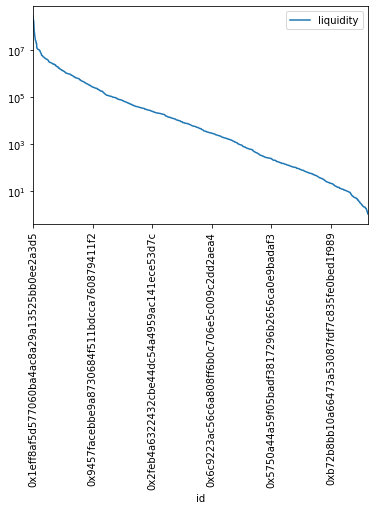

In [21]:
plt_df.plot(x='id', y='liquidity', logy=True)
plt.xticks(rotation=90)

In [22]:
plt_df['cumulative liquidity'] = plt_df.liquidity.cumsum()

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0.0, 0, '0x1eff8af5d577060ba4ac8a29a13525bb0ee2a3d5'),
  Text(200.0, 0, '0x9457facebbe9a8730684f511bdcca760879411f2'),
  Text(400.0, 0, '0x2feb4a6322432cbe44dc54a4959ac141ece53d7c'),
  Text(600.0, 0, '0x6c9223ac56c6a808ff6b0c706e5c009c2dd2aea4'),
  Text(800.0, 0, '0x5750a44a59f05badf3817296b2656ca0e9badaf3'),
  Text(1000.0, 0, '0xb72b8bb10a66473a53087fdf7c835fe0bed1f989'),
  Text(1200.0, 0, '')])

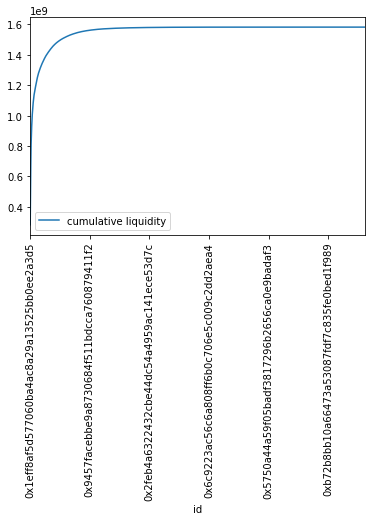

In [23]:
plt_df.plot(x='id', y='cumulative liquidity', logy=False)
plt.xticks(rotation=90)